<a href="https://colab.research.google.com/github/AlvielD/UNIBO-DL-2223/blob/main/lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab3: Segmentation

## Introduction
Three levels of image analysis:

* **Classification:** Given an image $x$ and return as output a class $y = f_\theta(x)$.
* **Object detection:** Given an image $x$, identify meaningful object inside of it, draw a rectangle that specify its position and classify each indetified object.
* **Segmentation:** Given an image $x$, classify each pixel of $x$ into one possible class.



---


This is generally done with a Convolutional Neural Network that act as an image-to-image transform, mapping each pixel of $x$ to the corresponding class.

*Remind:* Given an image $x \in \mathbb{R}^{m \times n \times c}$, an image-to-image map is a function $f: \mathbb{R}^{m \times n \times c} \to \mathbb{R}^{m' \times n' \times c'}$. In our situation, $m = m'$, $n = n'$ and $c = c'$. An image-to-image map is required to do segmentation and some image processing tasks, but not for classification or object detection. \\

Image-to-image maps are usually implemented by some variant of a Fully Convolutional Neural Network (FNN) design (e.g. ResNet, Autoencoders, ...). See https://heartbeat.comet.ml/a-2019-guide-to-semantic-segmentation-ca8242f5a7fc for details.




## Dataset: Carvana Image Masking Challenge

In our experiments today, we will use a famous dataset for image segmentation, which is called Carvana (https://www.kaggle.com/competitions/carvana-image-masking-challenge/overview). We need to download it:

* Login with you kaggle account on https://www.kaggle.com/ .
* Go to the link of the challenge and subscribe to the rules of the challenge.
* In Account, press Create New API Token. This will download a file named $\texttt{kaggle.json}$. Upload this file on Colab.
* Run the following.

In [1]:
# Install Kaggle library
!pip install kaggle

# Create a new folder .kaggle and move kaggle.json into that
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Allocate permissions for this file
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Download the data from the competition. If an error occours, either you did
# something wrong on the above or you forgot to subscribe the challenge.
!kaggle competitions download -c carvana-image-masking-challenge

100% 24.4G/24.4G [19:25<00:00, 21.5MB/s]
100% 24.4G/24.4G [19:25<00:00, 22.5MB/s]


In [ ]:
# The dataset is huge. For our experiments today, we just need a subset of it.
# Unzip train.zip and the corresponding masks. Not the HQ version.
!unzip -p carvana-image-masking-challenge.zip train.zip >train.zip
!unzip -p carvana-image-masking-challenge.zip train_masks.zip >train_masks.zip

# Unzip the zipped train files.
!unzip train.zip
!unzip train_masks.zip

## Setup

Import libraries and prepare the code.

In [4]:
# Utilities
import os

# Algebra
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Neural Networks
import tensorflow as tf
from tensorflow import keras as ks

In [5]:
def load_data_from_names(root_dir: str, fnames: list, shape=(256, 256)) -> np.array:
    # Given the root path and a list of file names as input, return the dataset 
    # array.
    images = []
    
    for idx, img_name in enumerate(fnames):
        x = Image.open(os.path.join(root_dir, img_name))
        x = x.resize(shape)
        x = np.array(x)
        images.append(x)

        if idx%100 == 99:
            print(f"Processed {idx+1} images.")
    return np.array(images)

# Load the names
image_names = os.listdir('./train')
mask_names = os.listdir('./train_masks')

image_names.sort()
mask_names.sort()

# To reduce the computational time, we consider only a subset of the dataset
N = 2000 # Number of total datapoints

image_names = image_names[:N]
mask_names = mask_names[:N]

# Create data. We will always use the notation that "x" is the input of the 
# network, "y" is the output.
x = load_data_from_names('./train', image_names)
y = load_data_from_names('./train_masks', mask_names)

# Print the dimension of the dataset.
print(f"The dimension of the dataset is: {x.shape}")

Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.
Processed 2000 images.
Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.
Processed 2000 images.
The dimension of the dataset is: (2000, 256, 256, 3)


In [6]:
# Split the training set into training and test.
TRAIN_SIZE = 1800

x_train = x[:TRAIN_SIZE]
y_train = y[:TRAIN_SIZE]

x_test = x[TRAIN_SIZE:]
y_test = y[TRAIN_SIZE:]

print(f"Train size: {x_train.shape}. Test size: {x_test.shape}")

Train size: (1800, 256, 256, 3). Test size: (200, 256, 256, 3)


## Visualization

Visualize some image and the corresponding mask.

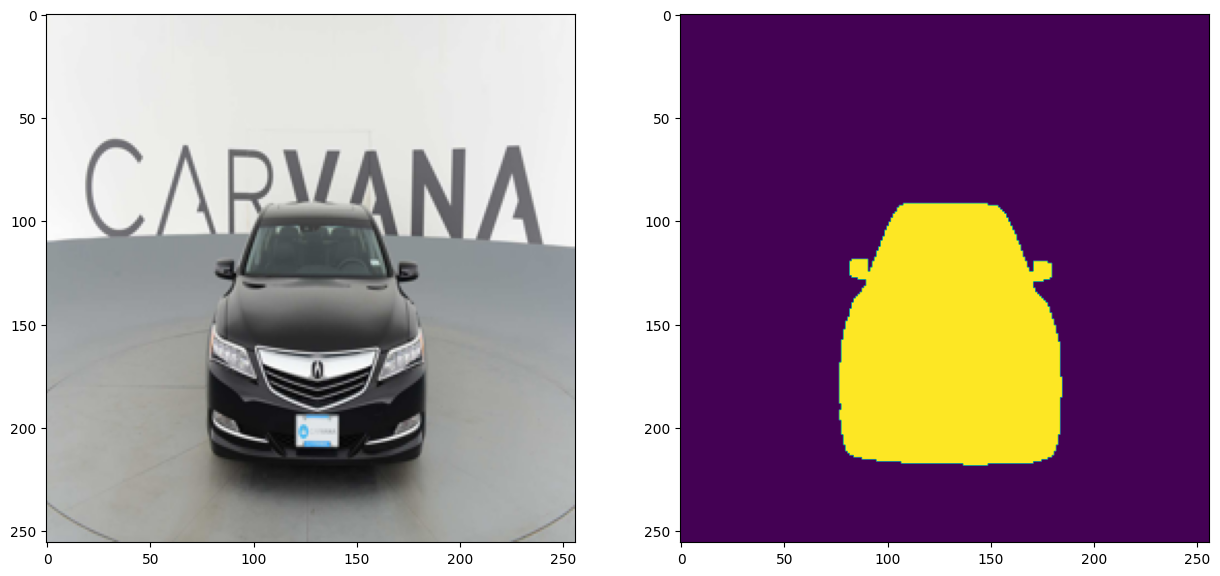

In [7]:
def show(x, y, title=None):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(x)
    if title:
        plt.title(title[0])
    
    plt.subplot(1, 2, 2)
    plt.imshow(y)
    if title:
        plt.title(title[1])

    plt.show()

show(x_train[0], y_train[0])

## Model

In [8]:
def build_cnn(input_shape, n_ch, L=3):
  """Builds a convolutional neural network 

  Parameters
  ----------
  input_shape : shape_like
  Shape of the input layer

  n_ch : int
  Number of channels

  L : int, optional
  Number of hidden layers

  """
  x = ks.layers.Input(shape=input_shape)

  h = x
  for i in range(L):
    h = ks.layers.Conv2D(n_ch, kernel_size=3, padding='same')(h)
    h = ks.layers.ReLU()(h)

    n_ch = 2*n_ch
  
  y = ks.layers.Conv2D(1, kernel_size=1, activation='sigmoid')(h)
  return ks.models.Model(x, y)

CNN_model = build_cnn((256, 256, 3), 64, L=3)
CNN_model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

print(CNN_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 re_lu (ReLU)                (None, 256, 256, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 128)     73856     
                                                                 
 re_lu_1 (ReLU)              (None, 256, 256, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 256)     295168    
                                                                 
 re_lu_2 (ReLU)              (None, 256, 256, 256)     0     

Epoch 1/20
102/102 [==============================] - 59s 379ms/step - loss: 0.9469 - accuracy: 0.8162 - val_loss: 0.3097 - val_accuracy: 0.8771
Epoch 2/20
102/102 [==============================] - 38s 372ms/step - loss: 0.2847 - accuracy: 0.8904 - val_loss: 0.2845 - val_accuracy: 0.8872
Epoch 3/20
102/102 [==============================] - 40s 389ms/step - loss: 0.2855 - accuracy: 0.8998 - val_loss: 0.3388 - val_accuracy: 0.8988
Epoch 4/20
102/102 [==============================] - 38s 377ms/step - loss: 0.3167 - accuracy: 0.8969 - val_loss: 0.2352 - val_accuracy: 0.9196
Epoch 5/20
102/102 [==============================] - 39s 385ms/step - loss: 0.2357 - accuracy: 0.9177 - val_loss: 0.2285 - val_accuracy: 0.9226
Epoch 6/20
102/102 [==============================] - 39s 381ms/step - loss: 0.2351 - accuracy: 0.9196 - val_loss: 0.2237 - val_accuracy: 0.9257
Epoch 7/20
102/102 [==============================] - 39s 382ms/step - loss: 0.2268 - accuracy: 0.9228 - val_loss: 0.2681 - val_ac

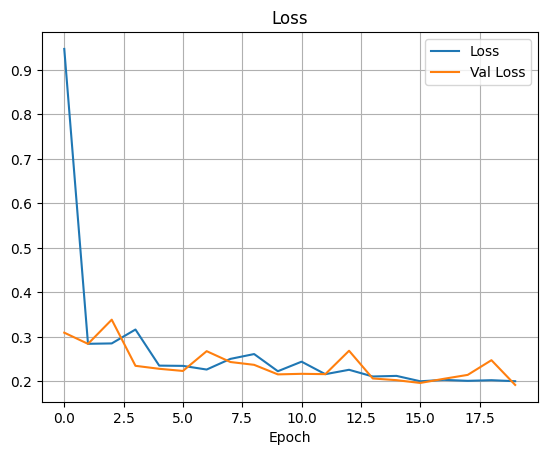

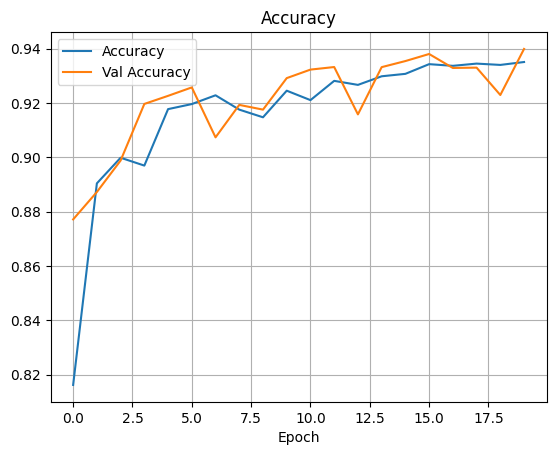

In [9]:
# Set hyperparameters
BATCH_SIZE = 16
N_EPOCHS = 20

# Training
hist = CNN_model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=N_EPOCHS,
              validation_split=0.1)

# Check overfit
loss_history = hist.history['loss']
val_loss_history = hist.history['val_loss']

acc_history = hist.history['accuracy']
val_acc_history = hist.history['val_accuracy']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')
plt.show()

plt.plot(acc_history)
plt.plot(val_acc_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'])
plt.title('Accuracy')
plt.show()

## Evaluation

There are multiple metrics used to measure the quality of the segmentation. The most important are:

* Accuracy
* Intersection over Union (IoU)
* Dice Coefficient

### Accuracy
The accuracy is simply defined by considering the segmentation as a pixel-by-pixel classification. \\

### Intersection over Union
The Intersection over Union (IoU) is pretty intuitive. It is defined as the ratio between the intersection area between the predicted mask and the ground truth mask, over the union between the two masks. 

![](https://miro.medium.com/max/300/0*kraYHnYpoJOhaMzq.png)

By using that the mask is a binary image, it is trivial to compute both the intersection and the union (the latter, computed via the relationship:

$$
\mu (A \cup B) + \mu (A \cap B) = \mu (A) + \mu (B)
$$

where $\mu(A)$ is defined to be the Area of A. \\

Clearly, $IoU(y, y') \in [0, 1]$, and $IoU(y, y') = 1$ in the best case, where $y$ and $y'$ overlap perfectly, and $IoU(y, y') = 0$ when they don't overlap.

### Dice coefficient
The Dice coefficient is defined by twice the overlapping area of the two masks, over the sum of the area of the two masks.

![](https://miro.medium.com/max/429/1*yUd5ckecHjWZf6hGrdlwzA.png)

The implementation of the dice coefficient is similar to the implementation of the IoU, since both of them explicitely uses that a mask is between 0 and 1.

In [10]:
from keras import backend as K
from keras.losses import binary_crossentropy

def iou_coeff(y_true, y_pred):
    smooth = 1

    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection

    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coeff(y_true, y_pred):
    smooth = 1

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# Function that evaluate the model on a dataset
def evaluate_model(model, x, y, fun):
    y_pred = model.predict(x) # Use the model to predict the output
    y = np.expand_dims(y, -1) # We need to add the channel dimension on y

    # Uniform the type of the array
    y_pred = y_pred.astype('float32')
    y = y.astype('float32')

    return fun(y, y_pred)

iou = evaluate_model(CNN_model, x_test,  y_test, iou_coeff)
dice = evaluate_model(CNN_model, x_test,  y_test, dice_coeff)

print(f"The IoU of the trained model is {iou}, while its Dice coefficient is {dice}.")

7/7 [==============================] - 2s 260ms/step
The IoU of the trained model is 0.5738331079483032, while its Dice coefficient is 0.731494665145874.


1/1 [==============================] - 1s 501ms/step


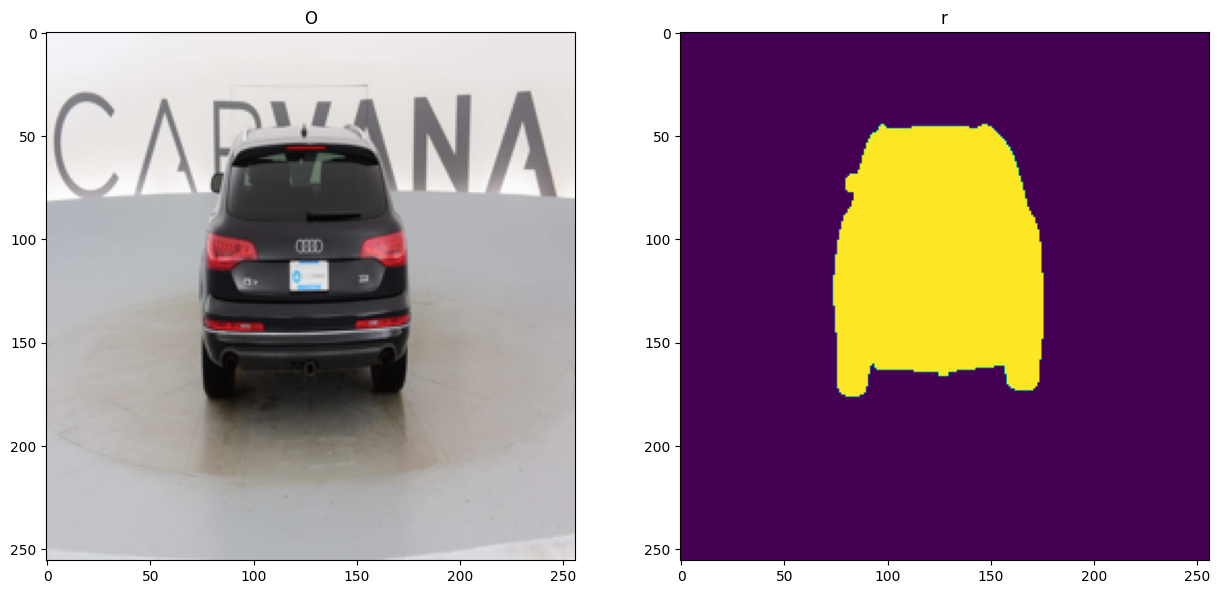

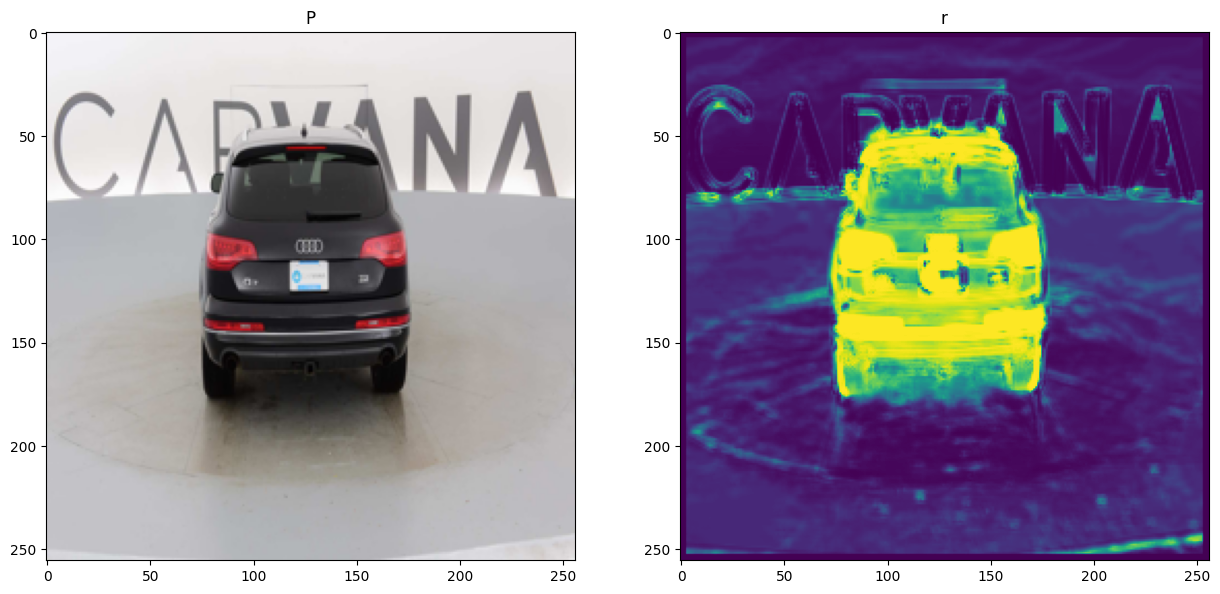

In [11]:
# Qualitative results
y_pred = CNN_model.predict(x_test[:1])

show(x_test[0, :, :], y_test[0, :, :], title='Original')
show(x_test[0, :, :], y_pred[0, :, :, 0], title='Predicted')

## UNet

Maybe the most known network architecture used for segmentation is the UNet. 

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

its architecture is based on the formula that you studied to compute the receptive field of a convolutional neural network:

$$
D' = S(D-1) + K
$$

where $D'$ is the receptive field of the previous layer, $D$ is the receptive field on the following layer, $S$ is the stride and $K$ is the kernel size. \\

A consequence of this formula is that the receptive field increases exponentially while moving down, linearly while moving right. \\

The drawback of downsampling, which is the information loss, is solved by UNet by adding skip connections, that also act as training stabilizer. \\

Note that, at every downsampling (which in this case is implemented as a MaxPooling2D layer), the number of filters double, to reduce the impact of the dimensionality loss (the total number of pixel after downsampling is divided by 4).

In [22]:
# Exercise: try to implement your version of UNet, based on the diagram above.
#           remember that the initial number of channels must be given as 
#           input and it doubles every time you go down.
#           Moreover, it is required that the number of "floors" of the network
#           must be a parameter. The same should happen for the number of each 
#           convolution per level.
#
#           Remember that, to go down, you need to use the MaxPooling2D operator
#           while to go up, a strided transpose convolution is required.
#
#
#
#           Train the UNet defined in this way on the dataset above. It performs
#           better or worse?
def build_unet(input_shape, n_ch=32, floors=4, n_conv=2):
  """Builds a model using the UNet architecture

  Parameters
  ----------
  input_shape : shape_like
  Shape of the input layer

  n_ch : int
  Number of channels

  floors : int
  Number of floors of the model

  n_conv : int
  Number of convolutions performed per level

  """
  x = ks.layers.Input(shape=input_shape)  # Define input layer
  h = x

  backup_layers = []  # Structure to keep the layers that will own skips

  # For each "floor" create a "n_conv" number of convolutional layers
  # GO DOWN IN THE NET FLOORS
  for i in range(floors-1):
    for j in range(n_conv):
      h = ks.layers.Conv2D(n_ch, kernel_size=3, padding='same', activation='relu')(h)
    backup_layers.append(h)           # Add layer to the skips layers
    h = ks.layers.MaxPooling2D()(h)   # MaxPooling before going to the next floor

    n_ch = 2*n_ch   # Increase number of channels for the next floor

  # BOTTOM FLOOR
  for i in range(n_conv):
    h = ks.layers.Conv2D(n_ch, kernel_size=3, padding='same', activation='relu')(h)

  n_ch = n_ch // 2  # Decrease the number of channels before starting to go up

  # GO UP IN THE NET FLOORS
  for i in range(floors-1):
    h = ks.layers.UpSampling2D()(h)                       # Perform upsampling before going up a level
    h = ks.layers.Concatenate()([h, backup_layers.pop(-1)]) # Concatenate the skip to the layer
    for j in range(n_conv):
      h = ks.layers.Conv2D(n_ch, kernel_size=3, padding='same', activation='relu')(h)

    n_ch = n_ch // 2  # Decrease the number of channels for the next floor

  y = ks.layers.Conv2D(1, kernel_size=1, activation='sigmoid')(h)
  return ks.models.Model(x, y)

unet_model = build_unet((256, 256, 3))
unet_model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

print(unet_model.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_92 (Conv2D)             (None, 256, 256, 32  896         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_92[0][0]']              
                                )                                                           

In [23]:
# Training
BATCH_SIZE = 16
N_EPOCHS = 20

hist = unet_model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=N_EPOCHS,
              validation_split=0.1)

Epoch 1/20
102/102 [==============================] - 37s 308ms/step - loss: 0.3540 - accuracy: 0.8996 - val_loss: 0.1097 - val_accuracy: 0.9606
Epoch 2/20
102/102 [==============================] - 28s 274ms/step - loss: 0.0679 - accuracy: 0.9752 - val_loss: 0.0690 - val_accuracy: 0.9752
Epoch 3/20
102/102 [==============================] - 28s 279ms/step - loss: 0.0436 - accuracy: 0.9842 - val_loss: 0.0464 - val_accuracy: 0.9829
Epoch 4/20
102/102 [==============================] - 29s 286ms/step - loss: 0.0300 - accuracy: 0.9890 - val_loss: 0.0350 - val_accuracy: 0.9873
Epoch 5/20
102/102 [==============================] - 29s 284ms/step - loss: 0.0245 - accuracy: 0.9909 - val_loss: 0.0336 - val_accuracy: 0.9875
Epoch 6/20
102/102 [==============================] - 30s 289ms/step - loss: 0.0215 - accuracy: 0.9920 - val_loss: 0.0278 - val_accuracy: 0.9898
Epoch 7/20
102/102 [==============================] - 29s 286ms/step - loss: 0.0186 - accuracy: 0.9929 - val_loss: 0.0257 - val_ac

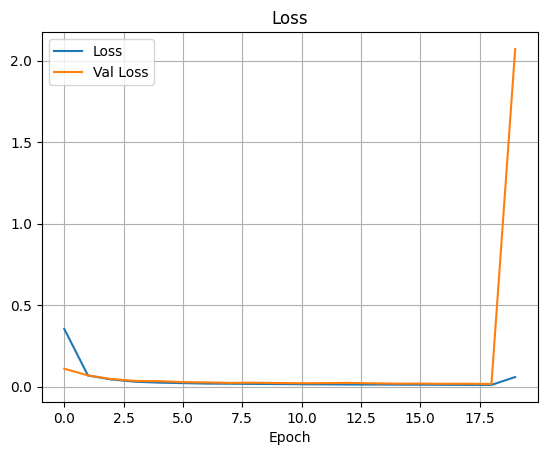

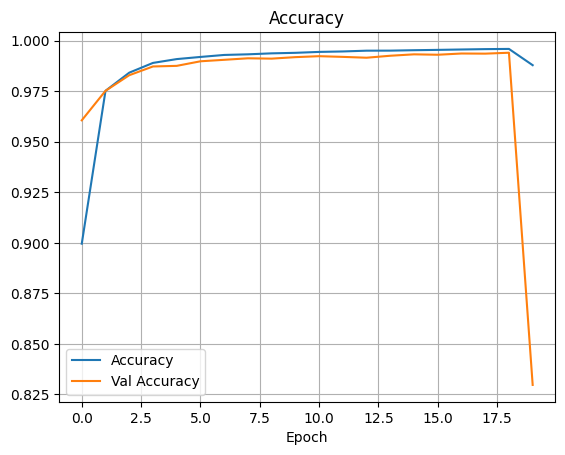

In [24]:
# Check overfit
loss_history = hist.history['loss']
val_loss_history = hist.history['val_loss']

acc_history = hist.history['accuracy']
val_acc_history = hist.history['val_accuracy']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')
plt.show()

plt.plot(acc_history)
plt.plot(val_acc_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'])
plt.title('Accuracy')
plt.show()

In [ ]:
unet_model.save_weights('segmentation_unet_train.h5')

In [25]:
iou = evaluate_model(unet_model, x_test,  y_test, iou_coeff)
dice = evaluate_model(unet_model, x_test,  y_test, dice_coeff)

print(f"The IoU of the trained model is {iou}, while its Dice coefficient is {dice}.")

7/7 [==============================] - 1s 157ms/step
The IoU of the trained model is 0.27319613099098206, while its Dice coefficient is 0.44248080253601074.


1/1 [==============================] - 1s 619ms/step


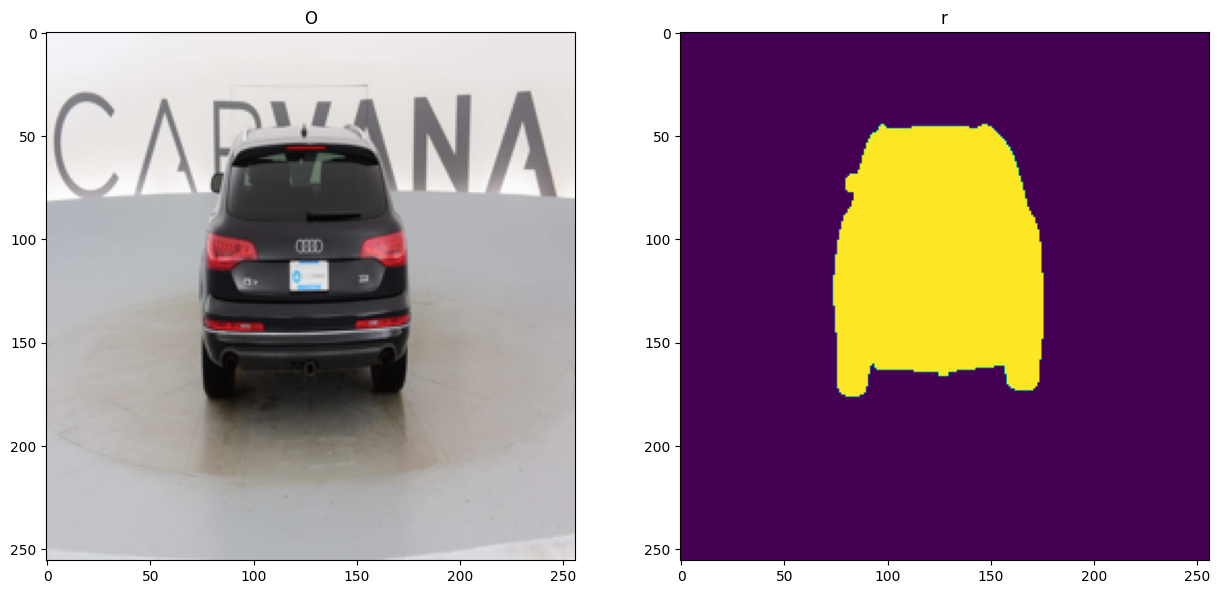

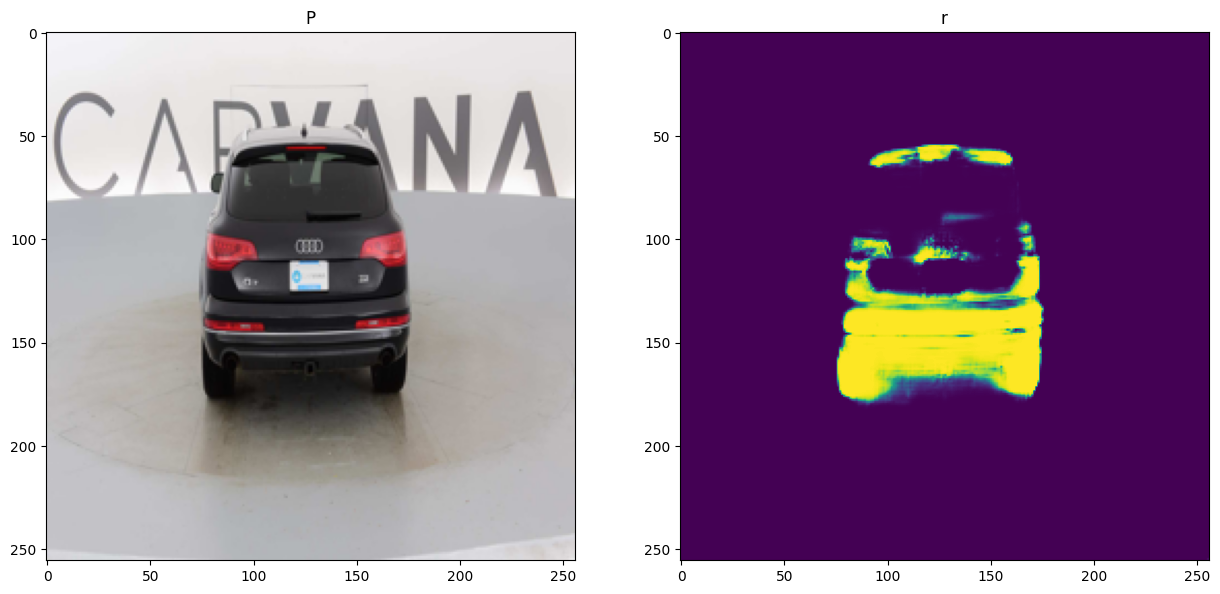

In [26]:
# Qualitative results
y_pred = unet_model.predict(x_test[:1])

show(x_test[0, :, :], y_test[0, :, :], title='Original')
show(x_test[0, :, :], y_pred[0, :, :, 0], title='Predicted')

## Data augmentation

When using a very powerful model (such as UNet) to solve a Segmentation task, there is a chance that your model will overfit. Given a fixed model, overfit happens strongly if the number of datapoints is small. Thus, a way to reduce overfitting is to enlarge the dimension of the dataset. \\

This is very easy to do in Segmentation. Given a (sufficiently regular) tranformation $T: \mathbb{R}^{m \times n \times c} \to \mathbb{R}^{m \times n \times c}$ and a dataset $\mathbb{D} = \{ (x_i, y_i) \}_{i=1}^N$, where $x_i$ is an image and $y_i$ is a mask with the same dimension of the corresponding image, we can create a new dataset $\mathbb{D}_{ex} = \{ (\tilde{x}_i, \tilde{y}_i) \}_{i=1}^{2N}$ where $\tilde{x}_i = x_i, \tilde{y}_i = y_i$ for $i = 1, \dots, N$, $\tilde{x}_i = T(x_i), \tilde{y}_i = T(y_i)$ for $i = N+1, \dots, 2N$. \\

This procedure can be repeated for multiple transormations $T$, to obtain a larger dataset. \\

*Warning:* Data augmentation via regular transformations $T$ does not add information to the dataset. As a consequence, the training complexity will increase linearly with the number of transformation we apply, without resulting in an improvement on the knowledge the model has. As a consequence, simply using tens of transormations to create a big dataset is not necessary a good idea. I suggest to use at most a couple of them, such as flipping, rotating or shifting.

In [27]:
def apply_transform(x_data, y_data, T):
    N = x_data.shape[0]

    new_x_data = np.zeros_like(x_data)
    new_y_data = np.zeros_like(y_data)

    for i in range(N):
        new_x_data[i] = T(x_data[i])
        new_y_data[i] = T(y_data[i])
    return new_x_data, new_y_data

def augment_data(x_data: np.array, y_data: np.array, transforms: list) -> np.array:
    new_x_data = x_data
    new_y_data = y_data

    for T in transforms:
        new_x, new_y = apply_transform(x_data, y_data, T)

        new_x_data = np.concatenate([new_x_data, new_x], axis=0)
        new_y_data = np.concatenate([new_y_data, new_y], axis=0)
    return new_x_data, new_y_data

# Augment our data with flipud and fliplr
transforms = [np.flipud, np.fliplr]
augmented_x_train, augmented_y_train = augment_data(x_train, y_train, transforms)

In [28]:
unet_model = build_unet((256, 256, 3))
unet_model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

print(unet_model.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_107 (Conv2D)            (None, 256, 256, 32  896         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_108 (Conv2D)            (None, 256, 256, 32  9248        ['conv2d_107[0][0]']             
                                )                                                           

In [29]:
# Training
BATCH_SIZE = 16
N_EPOCHS = 20

hist = unet_model.fit(augmented_x_train, augmented_y_train,
              batch_size=BATCH_SIZE,
              epochs=N_EPOCHS,
              validation_split=0.1)

Epoch 1/20
304/304 [==============================] - 100s 314ms/step - loss: 0.3413 - accuracy: 0.9162 - val_loss: 0.0712 - val_accuracy: 0.9729
Epoch 2/20
304/304 [==============================] - 87s 286ms/step - loss: 0.0585 - accuracy: 0.9774 - val_loss: 0.0352 - val_accuracy: 0.9865
Epoch 3/20
304/304 [==============================] - 89s 293ms/step - loss: 0.0305 - accuracy: 0.9883 - val_loss: 0.0297 - val_accuracy: 0.9888
Epoch 4/20
304/304 [==============================] - 86s 283ms/step - loss: 0.0231 - accuracy: 0.9911 - val_loss: 0.0207 - val_accuracy: 0.9920
Epoch 5/20
304/304 [==============================] - 86s 283ms/step - loss: 0.0197 - accuracy: 0.9924 - val_loss: 0.0186 - val_accuracy: 0.9928
Epoch 6/20
304/304 [==============================] - 86s 283ms/step - loss: 0.0176 - accuracy: 0.9932 - val_loss: 0.0192 - val_accuracy: 0.9926
Epoch 7/20
304/304 [==============================] - 86s 282ms/step - loss: 0.0160 - accuracy: 0.9938 - val_loss: 0.0154 - val_a

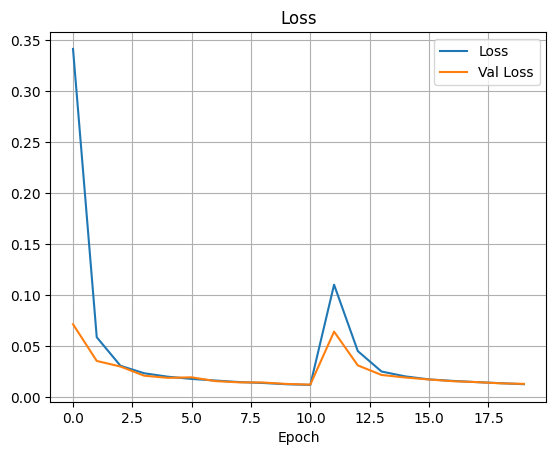

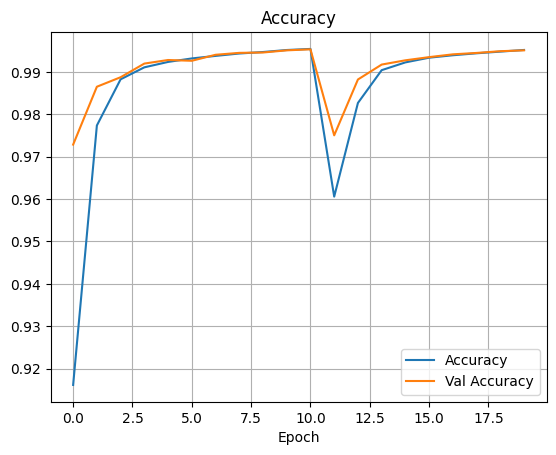

In [30]:
# Check overfit
loss_history = hist.history['loss']
val_loss_history = hist.history['val_loss']

acc_history = hist.history['accuracy']
val_acc_history = hist.history['val_accuracy']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')
plt.show()

plt.plot(acc_history)
plt.plot(val_acc_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'])
plt.title('Accuracy')
plt.show()

In [31]:
iou = evaluate_model(unet_model, x_test,  y_test, iou_coeff)
dice = evaluate_model(unet_model, x_test,  y_test, dice_coeff)

print(f"The IoU of the trained model is {iou}, while its Dice coefficient is {dice}.")

7/7 [==============================] - 1s 145ms/step
The IoU of the trained model is 0.964724600315094, while its Dice coefficient is 0.9820003509521484.


1/1 [==============================] - 0s 21ms/step


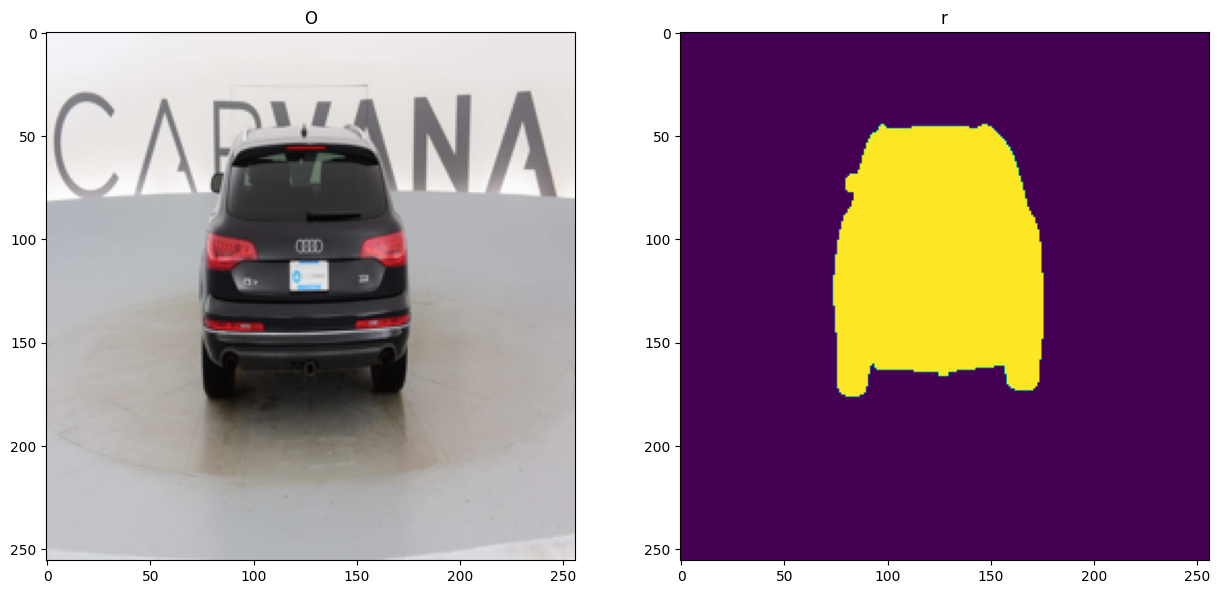

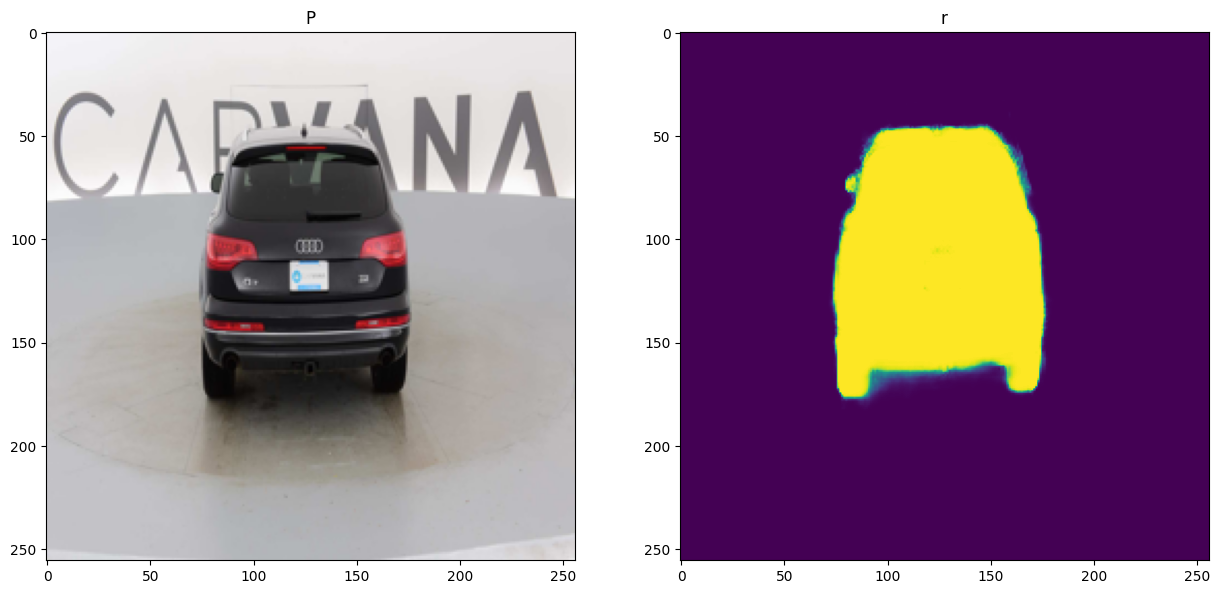

In [32]:
# Qualitative results
y_pred = unet_model.predict(x_test[:1])

show(x_test[0, :, :], y_test[0, :, :], title='Original')
show(x_test[0, :, :], y_pred[0, :, :, 0], title='Predicted')